In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import module_joaquin as mod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_excel("data/USD_SOFR.xlsx", index_col=0, header=0)
df.dropna(inplace=True)
df.head()

,USD1y1y,USD2y1y,USD3y1y,USD4y1y,USD5y2y,USD7y3y,USD10y5y,USD15y5y,USD20y5y,USD25y5y
Trade Day,,,,,,,,,,
2011-09-27,0.177201,0.613752,1.364864,2.038994,2.655216,3.057123,3.349836,3.160193,3.063415,2.944442
2011-09-28,0.181141,0.602388,1.394476,2.021346,2.639105,3.067483,3.334938,3.143473,3.047186,2.956431
2011-09-29,0.192427,0.678039,1.405417,2.085105,2.652564,3.058120,3.321548,3.118247,3.020588,2.954893
2011-09-30,0.193416,0.635942,1.323026,1.946972,2.605848,2.920937,3.154124,2.940650,2.832992,2.759629
2011-10-03,0.179286,0.588597,1.215862,1.801201,2.345519,2.704160,2.933541,2.733042,2.631103,2.530194


In [4]:
# Go to decimal scale (1bp = 0.0001; 1% = 0.01)
train_df = df[df.index < "2020-01-01"] * 0.01
test_df = df[~(df.index < "2020-01-01")] * 0.01

In [5]:
# compute the PCA score time-series.
# Note that PCA windows are being hyperparameters of the trading model.
train_scores, train_pca = mod.rolling_pca(train_df,
                                          corr_window_size=252,
                                          vol_window_size=60,
                                          recalibration_period=30)

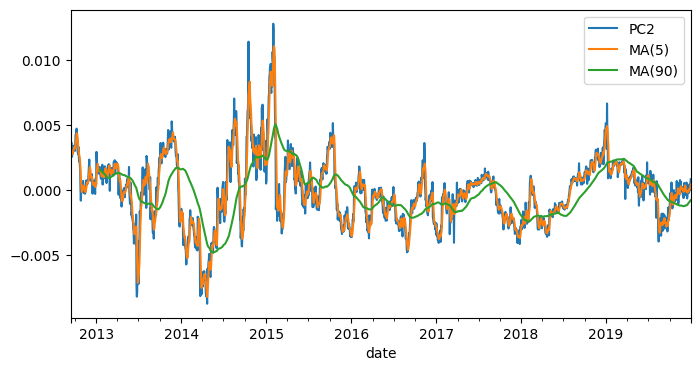

In [33]:
# Short visualization
short_ma_window = 5
long_ma_window = 90
short_ma = train_scores["PC2"].rolling(short_ma_window).mean()
long_ma = train_scores["PC2"].rolling(long_ma_window).mean()

plt.figure(figsize=(8, 4))
train_scores["PC2"].plot(label="PC2")
short_ma.plot(label=f"MA({short_ma_window})")
long_ma.plot(label=f"MA({long_ma_window})")
plt.legend()
plt.show()

### Optimizing MA startegy parameters

In [11]:
portfolio = np.array([
    -1.0, #1Y
    0,    #2Y
    0,    #3Y
    0,    #4Y
    0,    #5Y
    0,    #7Y
    1.0,  #10Y
    0,    #15Y
    0,    #20Y
    0,    #25Y
])


In [27]:
from scipy.optimize import brute

def neg_ema_strat_sharpe(X):
    short, long, threshold = X
    # enforce integer EMAs & simple constraints
    short = int(round(short))
    long  = int(round(long))
    threshold = float(threshold)

    if short < 1 or long <= short:
        return 1e6
    sharpe = mod.ema_strat_trading_sharpe(train_scores, train_pca, train_df, portfolio, short, long, threshold)
    # If your ema_strat_sharpe returns -inf on bad configs, penalize
    if not np.isfinite(sharpe):
        return 1e6

    return -sharpe   # because we want to MAXIMIZE the Sharpe

# slice(start, stop, step) — stop is INCLUDED by brute
rranges = (
    slice(5, 31, 5),        # short: 5,10,15,20,25,30
    slice(50, 201, 10),     # long: 50,60,...,200
    slice(0.0, 0.01000001, 5e-5),  # threshold: pace 0.5 bp
)

best_x, best_f, grid_vals, grid_sharpes = brute(
                                    neg_ema_strat_sharpe,
                                    rranges,
                                    full_output=True,
                                    finish=None,
                                )

best_short     = int(round(best_x[0]))
best_long      = int(round(best_x[1]))
best_threshold = float(best_x[2])
best_sharpe    = -best_f

print("Best params via brute:")
print("  short     =", best_short)
print("  long      =", best_long)
print("  threshold =", best_threshold)
print("  Sharpe    =", best_sharpe)

Best params via brute:
  short     = 5
  long      = 190
  threshold = 0.0027500000000000003
  Sharpe    = 0.6451370537732257


<Axes: xlabel='date'>

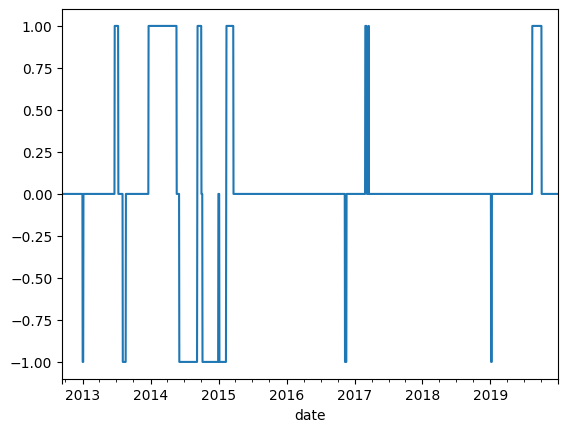

In [37]:
trades, df2 = mod.ema_strat(train_scores,
                            train_pca,
                            train_df,
                            portfolio,
                            short=5, long=190, threshold=0.0015)
df2["position"].plot()

In [38]:
df_trades = pd.DataFrame(trades)
df_trades.drop(columns=["pc_loading", "portfolio","mtm"], inplace=True)
df_trades

,entry_date,exit_date,position,days,pnl,vol
0,2013-01-01,2013-01-04,-1,4,-6.79,5.917
1,2013-06-21,2013-07-11,1,15,17.47,6.072
2,2013-08-05,2013-08-21,-1,13,-8.37,3.322
3,2013-12-20,2014-05-21,1,109,-83.59,4.136
4,2014-06-04,2014-09-09,-1,70,83.19,4.576
5,2014-09-10,2014-10-01,1,16,-22.84,5.163
6,2014-10-07,2014-12-31,-1,62,69.29,6.022
7,2015-01-06,2015-02-11,-1,27,3.35,9.681
8,2015-02-12,2015-03-23,1,28,0.38,5.471
9,2016-11-10,2016-11-18,-1,7,40.57,8.441


In [40]:
sharpe = mod.ema_strat_trading_sharpe(train_scores, train_pca, train_df, portfolio,
                                            short=5, long=90, threshold=0.0015)
sharpe

np.float64(0.07986221835265114)